In [79]:
from pymongo import MongoClient
import pandas as pd
from parse_clean_store import (parse_route_page, parse_user)
from bs4 import BeautifulSoup
from matrix_recommender_prep import (clean_ratings, cold_start, update_df)
import numpy as np
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc

(<pyspark.sql.session.SparkSession at 0x7fc6e40d1750>,
 <pyspark.context.SparkContext at 0x7fc70748d8d0>)

In [7]:
client = MongoClient('mongodb://localhost:27017/')
db = client.ratings_collection
ratings_collection = db.ratings_collection
raw_data = ratings_collection.find()
df_ratings = pd.DataFrame(list(raw_data))
df_ratings.head()

,_id,rating,route,username
0,58c87f8c40b44102a84aedfb,[1],30(1) Feet of Pleasure,[adam winslow ]
1,58c87f9d40b44102a84aee01,[1],41 Feet of Pain,[adam winslow ]
2,58c87fac40b44102a84aee07,"[1, 1, 1, 1]",5.5 Crack,"[CHopwood , Trevor. , Rickedge , Oscar Edge ]"
3,58c87fb440b44102a84aee0d,"[3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",5.6 crack,"[Bianca P , Sandeep Kumar , Mike Brady , Tom B..."
4,58c87fbf40b44102a84aee13,"[2, 2, 2, 2, 1, 1, 1, 1, 1]",5.6 Dihedral,"[Jason Killgore , sqwirll , Dave Leydet , fort..."


In [10]:
df = cold_start(df_ratings)
df.head()

,30(1) Feet of Pleasure,41 Feet of Pain,5.5 Crack,5.6 crack,5.6 Dihedral,5.7,5.7 Face,A,A Crack,A MIGHTY WIND,...,Town Crier,TPMV (10% Meteorological Vinculation),Tradical,Tree Hugger,Trigger Finger,Trobability Pest,Twelve Gauge IQ,Under Arrest,Under the Influence,Unicorn Blues
adam winslow,1.0,1.0,1.0,2.029412,1.444444,2.0,1.692308,NaN,1.0,3.0,...,3.545455,3.928571,4.0,3.0,4.0,3.0,4.0,2.615385,2.0,4.0
CHopwood,1.0,1.0,1.0,2.029412,1.444444,2.0,1.692308,NaN,1.0,3.0,...,3.545455,3.928571,4.0,3.0,4.0,3.0,4.0,2.615385,2.0,4.0
Trevor.,1.0,1.0,1.0,2.029412,1.444444,2.0,1.692308,NaN,1.0,3.0,...,3.545455,3.928571,4.0,3.0,4.0,3.0,4.0,2.615385,2.0,4.0
Rickedge,1.0,1.0,1.0,2.029412,1.444444,2.0,1.692308,NaN,1.0,3.0,...,3.545455,3.928571,4.0,3.0,4.0,3.0,4.0,2.615385,2.0,4.0
Oscar Edge,1.0,1.0,1.0,2.029412,1.444444,2.0,1.692308,NaN,1.0,3.0,...,3.545455,3.928571,4.0,3.0,4.0,3.0,4.0,2.615385,2.0,4.0


In [49]:
ratings_df_pd = update_df(df_ratings)
ratings_df_pd.head()

,username,route,rating
2,1705,28,1
4,1705,29,1
6,281,34,1
7,1620,34,1
8,1346,34,1


In [50]:
# Convert to a Spark DataFrame, dropping `timestamp` column
ratings_df = spark.createDataFrame(ratings_df_pd)

In [51]:
# Check to see we built the DataFrame
ratings_df

DataFrame[username: bigint, route: bigint, rating: bigint]

In [52]:
# Take a look at the entries in the DataFrame
ratings_df.show(5)

+--------+-----+------+
|username|route|rating|
+--------+-----+------+
|    1705|   28|     1|
|    1705|   29|     1|
|     281|   34|     1|
|    1620|   34|     1|
|    1346|   34|     1|
+--------+-----+------+
only showing top 5 rows



In [53]:
train, test = ratings_df.randomSplit([0.8, 0.2], seed=427471138)

In [54]:
# Check to see our split worked
train.count(), test.count()

(23756, 6014)

In [55]:
als_model = ALS(userCol='username',
                itemCol='route',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

In [56]:
recommender = als_model.fit(train)

In [65]:
# Build a single row DataFrame
data = [(1, 100)]
columns = ('username', 'route')
one_row_spark_df = spark.createDataFrame(data, columns)

In [66]:
# Check that it worked
one_row_spark_df.show()

+--------+-----+
|username|route|
+--------+-----+
|       1|  100|
+--------+-----+



In [67]:
# Get the factors for user 1 and movie 100
user_factor_df = recommender.userFactors.filter('id = 1')
item_factor_df = recommender.itemFactors.filter('id = 100')

In [68]:
user_factors = user_factor_df.collect()[0]['features']
item_factors = item_factor_df.collect()[0]['features']

In [69]:
# Manually (sorta) calculate the predicted rating
np.dot(user_factors, item_factors)

2.2541360503189787

In [70]:
# Get the recommender's prediction
recommender.transform(one_row_spark_df).show()

+--------+-----+----------+
|username|route|prediction|
+--------+-----+----------+
|       1|  100|  2.254136|
+--------+-----+----------+



In [71]:
# Let's take a look all the user factors
recommender.userFactors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[0.5931131, 0.323...|
| 10|[0.7210115, 0.162...|
| 20|[0.2531046, 0.198...|
| 30|[0.27939722, 0.39...|
| 40|[0.60345566, 0.64...|
| 50|[0.6707148, 0.720...|
| 60|[0.1809726, 0.210...|
| 70|[0.6830261, 0.351...|
| 80|[0.7285145, 0.428...|
| 90|[0.9272695, 0.031...|
|100|[0.10871197, 0.51...|
|110|[0.23463938, 0.0,...|
|130|[0.20191732, 0.61...|
|140|[0.25224268, 0.85...|
|150|[0.727549, 0.2959...|
|160|[0.6650526, 0.159...|
|170|[0.7902609, 0.474...|
|180|[0.40805548, 0.71...|
|190|[0.86534035, 0.57...|
|200|[0.65456563, 0.43...|
+---+--------------------+
only showing top 20 rows



In [72]:
# Make predictions for the whole test set
predictions = recommender.transform(test)

In [73]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [74]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [75]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [76]:
predictions_df.describe()

,username,route,rating,prediction,squared_error
count,6014.000000,6014.000000,6014.000000,6014.000000,6.014000e+03
mean,1060.730961,1783.611074,2.703026,2.538594,5.056158e-01
std,599.803735,1002.985254,0.899730,0.690687,8.298224e-01
min,0.000000,0.000000,0.000000,0.000000,3.356547e-07
25%,568.000000,899.250000,2.000000,2.051087,5.462727e-02
50%,1069.000000,1805.000000,3.000000,2.597881,2.069278e-01
75%,1619.750000,2668.000000,3.000000,2.995571,5.722123e-01
max,2064.000000,3557.000000,4.000000,4.765341,1.600000e+01


In [77]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.71106669501393338

ValueError: zero-size array to reduction operation minimum which has no identity

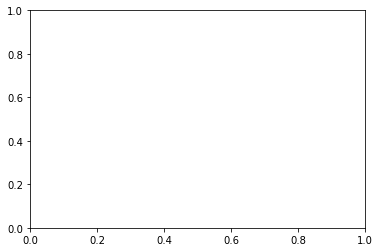

In [80]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 6)]
plt.violinplot(data, range(1,6), showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs. ALS Recommender Predicted Ratings')
plt.show()